In [1]:
# Load libraries
import math
import sys
import h5py
import pandas as pd
import numpy as np
from numpy.fft import fft, ifft
from scipy import interpolate
import matplotlib.pyplot as plt
import pywt
from scipy.io import loadmat, savemat
from scipy import signal
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
import keras.backend as K
from keras.models import Sequential,  Model
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from tensorflow.keras import layers
from tensorflow import keras
from keras.layers import MaxPooling2D, Conv2D, MaxPooling1D, Conv1D, Dense, Flatten, AveragePooling1D, LSTM, Dropout, Input, Concatenate, LeakyReLU, BatchNormalization, Activation
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from google.colab import files
from numpy import savetxt
from keras.layers import Layer
from xgboost import XGBRegressor
from matplotlib import pyplot
np.random.seed(0)
tf.random.set_seed(0)

In [2]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load Data**

In [3]:
# Load raw ultrasonic data
data1 = np.load('/content/drive/My Drive/Colab Notebooks/p5270/Labquake_prediction/Data_Extraction/Data/NPData/Npclean1.npz')
data2 = np.load('/content/drive/My Drive/Colab Notebooks/p5270/Labquake_prediction/Data_Extraction/Data/NPData/Npclean2.npz')
data3 = np.load('/content/drive/My Drive/Colab Notebooks/p5270/Labquake_prediction/Data_Extraction/Data/NPData/Npclean3.npz')
data4 = np.load('/content/drive/My Drive/Colab Notebooks/p5270/Labquake_prediction/Data_Extraction/Data/NPData/Npclean4.npz')
data5 = np.load('/content/drive/My Drive/Colab Notebooks/p5270/Labquake_prediction/Data_Extraction/Data/NPData/Npclean5.npz')

In [4]:
# Get training time
def truncate(n,i):
  return math.floor(n*10**i)/10**i

train_time = np.concatenate((data1['Time'], data2['Time'], data3['Time'], data4['Time'], data5['Time']), axis=None)
ttime = [truncate(i,2) for i in train_time]
print(np.shape(ttime))
ttime = np.reshape(ttime, (np.shape(ttime)[0], 1))
print(ttime)
print(np.shape(ttime))

del train_time

(1324032,)
[[2102.67]
 [2102.67]
 [2102.67]
 ...
 [3426.96]
 [3426.96]
 [3426.96]]
(1324032, 1)


In [5]:
# Collect raw ultrasonic data
train_data = np.concatenate((data1['AcData'], data2['AcData'], data3['AcData'], data4['AcData'], data5['AcData']), axis=0)
print(train_data)
print(np.shape(train_data))

[[ 21   9  26 ... -31 -33 -45]
 [ 17  20  28 ... -25 -30 -41]
 [  8  10  17 ... -17 -20 -38]
 ...
 [ 21  30  29 ... 232 242 238]
 [ 27  10  20 ... 248 239 228]
 [ 58  93 111 ... 249 224 216]]
(1324032, 1568)


In [6]:
# Delete raw ultrasonic data
del data1, data2, data3, data4, data5

In [7]:
# Combine ultrasound data & time
ttime = pd.DataFrame(ttime).rename(columns={0:'Time'})
full_df = ttime.join(pd.DataFrame(train_data))
print(full_df)
del train_data, ttime

            Time   0   1    2    3    4   5   6   7   8  ...  1558  1559  \
0        2102.67  21   9   26   20   31  43  25  20  31  ...     4    -6   
1        2102.67  17  20   28   24   29  40  40  35  44  ...    -6   -10   
2        2102.67   8  10   17   13   32  45  29  25  22  ...     2    -9   
3        2102.67   2   5   14    8   17  21  11  15  19  ...     3     2   
4        2102.67  15  15   10   22   29  34  19  19  27  ...    -1     3   
...          ...  ..  ..  ...  ...  ...  ..  ..  ..  ..  ...   ...   ...   
1324027  3426.96  24  22   18   36   36  26  24  19  21  ...   248   260   
1324028  3426.96  24  16   21   32   31  27  22  15  34  ...   258   261   
1324029  3426.96  21  30   29   30   25  35  34  30  36  ...   268   275   
1324030  3426.96  27  10   20   29   28  29  38  21  25  ...   265   258   
1324031  3426.96  58  93  111  124  115  89  44  35  19  ...   256   269   

         1560  1561  1562  1563  1564  1565  1566  1567  
0           1    -2   -11   -

In [8]:
# Drop duplicate time data
full_df = full_df.drop_duplicates(subset=['Time'], keep='last').reset_index(drop=True)
full_df = full_df.set_index('Time')
print(full_df)

         0     1     2     3     4     5     6     7     8     9     ...  \
Time                                                                 ...   
2102.67    20    17    14    13    35    49    37    37    23    19  ...   
2102.68    10    16    20    13    34    34    33    37    24    16  ...   
2102.69    18    14    18    28    23    31    26    22    20     4  ...   
2102.70    26    13    22    26    25    35    25    25    40    14  ...   
2102.71    14    11     9    20    31    34    29     2     5    13  ...   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
3426.92     9    18    19    16    41    23    12    29    18     3  ...   
3426.93    17    24    16    23    19    17    20    21    28    12  ...   
3426.94    10    12    25    13    27    50    25    27    19     2  ...   
3426.95     3    15    21    23    39    38    21    23    22    15  ...   
3426.96    58    93   111   124   115    89    44    35    19   -14  ...   

         15

In [9]:
# Load shear stress data
data = loadmat('/content/drive/My Drive/Colab Notebooks/p5270/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')
m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'SS':data['SS'].ravel()})
m_t = m_t[:][175604:175604+132430].reset_index(drop=True)
print(m_t)

           Time        SS
0       2102.91  5.657157
1       2102.92  5.658317
2       2102.93  5.659499
3       2102.94  5.660404
4       2102.95  5.661648
...         ...       ...
132425  3427.16  5.525714
132426  3427.17  5.526729
132427  3427.18  5.527665
132428  3427.19  5.528600
132429  3427.20  5.529378

[132430 rows x 2 columns]


In [10]:
# Merge raw ultrasonic data & shear stress based on time
# Prepare input data (xdf): raw ultrasonic signal
# Prepare output data (ydf): shear stress
df = full_df.reset_index().merge(m_t, on='Time').reset_index(drop=True)
print(df)
xdf = df.drop(['Time', 'SS'], axis=1)
ydf = df[['SS']]
print(xdf)
print(ydf)

           Time   0   1    2    3    4   5   6   7   8  ...  1559  1560  1561  \
0       2102.91  16  23   16   31   33  27  24  26  32  ...     3    13    -4   
1       2102.92  15  19   32   30   31  40  34  28  37  ...   -13     1    -7   
2       2102.93   9  16   20   27   36  44  21  10  26  ...     5     3     9   
3       2102.94  26  24   21   22   27  36  28  24  17  ...    -4    -4   -11   
4       2102.95  10  14   24   28   35  36  26  25  17  ...     6    -1    -9   
...         ...  ..  ..  ...  ...  ...  ..  ..  ..  ..  ...   ...   ...   ...   
132377  3426.92   9  18   19   16   41  23  12  29  18  ...   264   265   250   
132378  3426.93  17  24   16   23   19  17  20  21  28  ...   266   261   263   
132379  3426.94  10  12   25   13   27  50  25  27  19  ...   271   255   268   
132380  3426.95   3  15   21   23   39  38  21  23  22  ...   259   247   258   
132381  3426.96  58  93  111  124  115  89  44  35  19  ...   269   265   259   

        1562  1563  1564  1

In [11]:
# Select signal
WFnew = xdf.iloc[:,:]
print(WFnew.shape)

(132382, 1568)


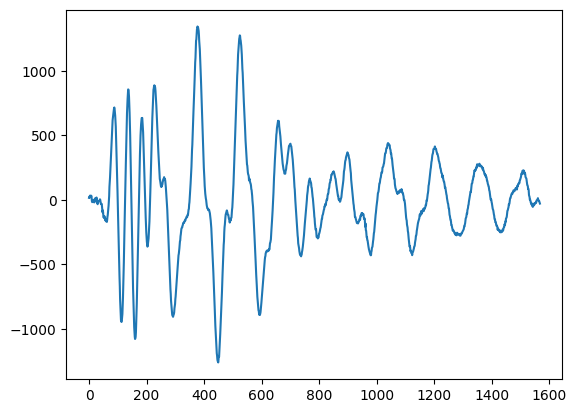

In [12]:
sig = WFnew.iloc[0,:]
plt.plot(sig)

In [13]:
# FFT Function
def fft_oneside(U2,fs):

    A = fft(U2)
    N = len(A)
    dt = 1/fs
    df=1/((N-1)*dt)
    fN=(1/dt)/2
    f_oneside=np.linspace(0,fN,int(fN/df))
    A_oneside=A[0:len(f_oneside)]

    return f_oneside, abs(A_oneside);

In [14]:
# Zeropadding
down_fact = 1
fs = (25e6)/down_fact
zpad = 2048
zros = np.zeros((len(WFnew),zpad))
xpad = np.append(WFnew, zros, axis=1)
print(xpad.shape)

(132382, 3616)


In [15]:
# Run loop for fft
f_loop = np.zeros((132382,1807))
Amp_loop = np.zeros((132382,1807))
for i in range(len(WFnew)):
  # print(i)
  xpadloop = xpad[i,:]
  f_loop[i], Amp_loop[i] = fft_oneside(xpadloop,fs)

Text(0, 0.5, 'Amplitude (a.u.)')

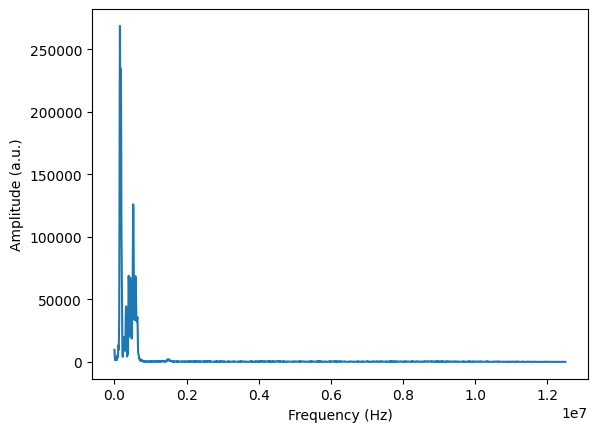

In [16]:
plt.plot(f_loop[0,:],Amp_loop[0,:])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (a.u.)')
# plt.xlim([0,100])

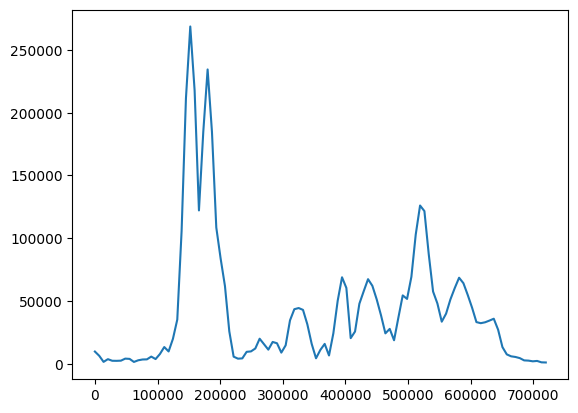

In [17]:
plt.plot(f_loop[0,0:105],Amp_loop[0,0:105])
# plt.xlim([0,100])

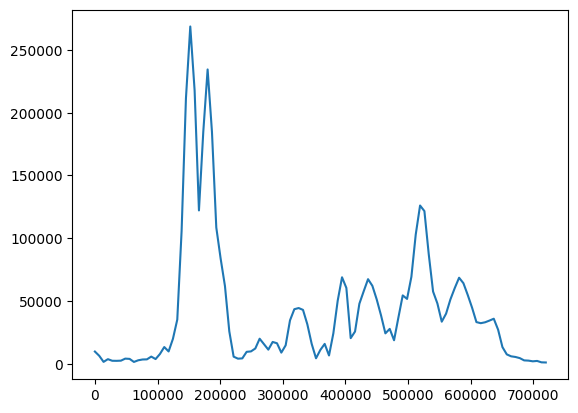

In [18]:
plt.plot(f_loop[0,0:105],Amp_loop[0,0:105])

Text(0, 0.5, 'Amplitude (a.u.)')

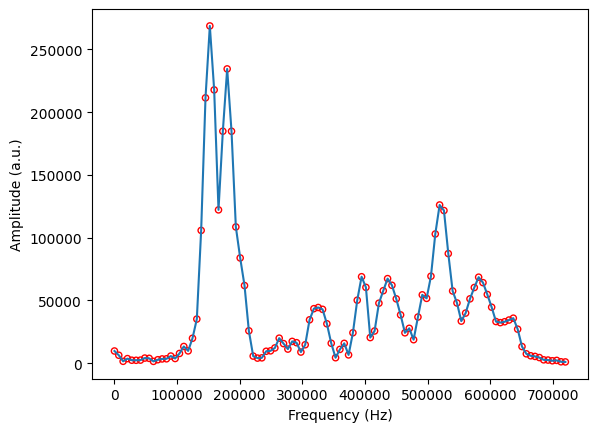

In [19]:
# Reduce Data
f_loop = f_loop[:,0:105]
Amp_loop = Amp_loop[:,0:105]

plt.plot(f_loop[0,:], Amp_loop[0,:])
plt.scatter(f_loop[0,:], Amp_loop[0,:], s=20, facecolors='none', edgecolors='r')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (a.u.)')

In [20]:
# Shape
in_dim = Amp_loop[1].shape
print(Amp_loop[1].shape)
print(in_dim)

(105,)
(105,)


In [21]:
# Split into train-val-test
x_train, x_test, y_train, y_test = train_test_split(Amp_loop, ydf, test_size=0.2, random_state=0, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=0, shuffle=False)

In [22]:
# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

In [23]:
del xdf, data, df, full_df, m_t, zros, x_train, y_train

In [24]:
# Define DD
def MLP_Data():

    # Define inputs
    X_train_new = layers.Input(shape=(in_dim),name='Input_Layer')

    # Prediction: Shear Stress
    x = layers.Dense(1, activation="linear", use_bias=False, kernel_initializer = 'normal', name='Weights_Layer')(X_train_new)
    ss_pred = layers.Dense(1, activation="linear", kernel_initializer = 'normal', name='Output_Layer')(x)

    model = keras.Model(inputs=[X_train_new],outputs=[ss_pred])
    return model

In [25]:
# Model Summary
model=MLP_Data()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 105)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Weights_Layer (Dense)           │ (None, 1)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107 (428.00 B)

 Trainable params: 107 (428.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2883/2896 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9028
Epoch 1: val_loss improved from inf to 0.03244, saving model to /content/drive/My Drive/Colab Notebooks/Entire_Signal/Automatic_Physics_Guided_Features_Extraction/Check.keras
2896/2896 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 6.8785 - val_loss: 0.0324
Epoch 2/100
2878/2896 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0363
Epoch 2: val_loss did not improve from 0.03244
2896/2896 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0363 - val_loss: 0.0399
Epoch 3/100
2882/2896 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0319
Epoch 3: val_loss did not improve from 0.03244
2896/2896 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0319 - val_loss: 0.0349
Epoch 4/100
2891/2896 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0271
Epoch 4: val_loss improved from 0.03244 to 0.02956, saving model to /content/drive/My Drive/Colab Notebooks/Entire_Signal/Automatic_Physics_Guided_Features_Extraction/Check.keras
2896/2896 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/ste

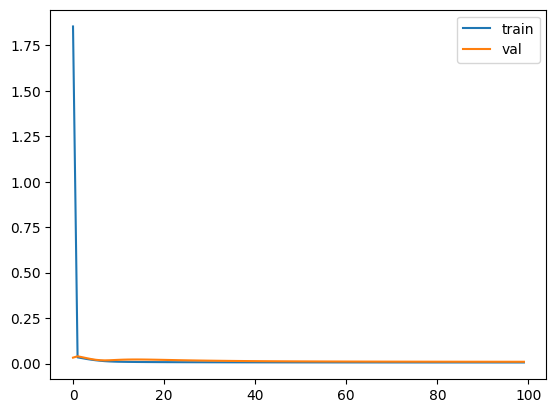

In [26]:
# Compile & Run
model=MLP_Data()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3))
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto')
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/Entire_Signal/Automatic_Physics_Guided_Features_Extraction/Check.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit([X_train],[Y_train], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val]), verbose=1)
end_time = time.time()
print("\n---Training Time: %0.8f seconds ---" % (end_time - start_time))
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [27]:
# Extract Weights
names = [weight.name for layer in model.layers for weight in layer.weights]
weights = model.get_weights()

for name, weight in zip(names, weights):
    print(name, weight.shape)

kernel (105, 1)
kernel (1, 1)
bias (1,)


In [28]:
# Display Weights
model.get_weights()

[array([[-2.96459854e-01],
        [ 2.97458470e-01],
        [-1.05396705e-02],
        [ 1.79770291e-01],
        [-1.42755285e-01],
        [ 8.75116214e-02],
        [-4.84719351e-02],
        [-6.13918826e-02],
        [-7.85819530e-01],
        [-1.07151784e-01],
        [-1.61696598e-02],
        [-1.81324393e-01],
        [-1.06735475e-01],
        [ 2.74290562e-01],
        [-1.16688512e-01],
        [-1.84410512e+00],
        [-2.01701775e-01],
        [ 2.85833430e+00],
        [-1.72322965e+00],
        [ 2.21511936e+00],
        [-1.04540014e+00],
        [ 7.37737596e-01],
        [ 8.02821890e-02],
        [-3.58040631e-01],
        [ 1.46205354e+00],
        [ 3.71451586e-01],
        [-2.70494640e-01],
        [-1.38547108e-01],
        [-2.28433561e+00],
        [ 2.19093263e-01],
        [-1.06509849e-01],
        [-8.37122127e-02],
        [-1.04245067e+00],
        [-2.22653702e-01],
        [-1.20915957e-01],
        [ 4.39893097e-01],
        [-7.71030486e-01],
 

In [29]:
# Extract weight
importance = model.get_layer('Weights_Layer').get_weights()[0]
print(importance.shape)
max_importance = np.max(importance)
min_importance = np.min(importance)
mean_importance  = np.mean(importance)
print(max_importance)
print(min_importance)
print(mean_importance)

(105, 1)
2.8583343
-2.2843356
-0.031341143


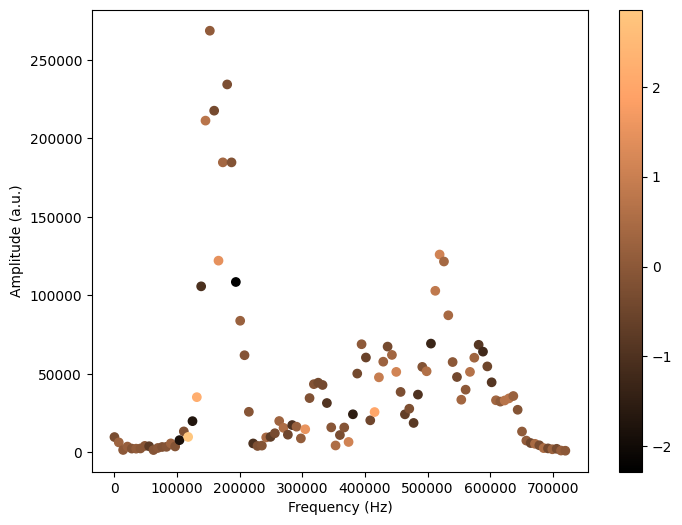

In [30]:
# Plot freq, Amp with imporance
plt.figure(figsize=(8, 6))
plt.scatter(f_loop[0,:],Amp_loop[0,:],c = importance, cmap = 'copper')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (a.u.)")
# plt.title("Weights")
plt.colorbar()

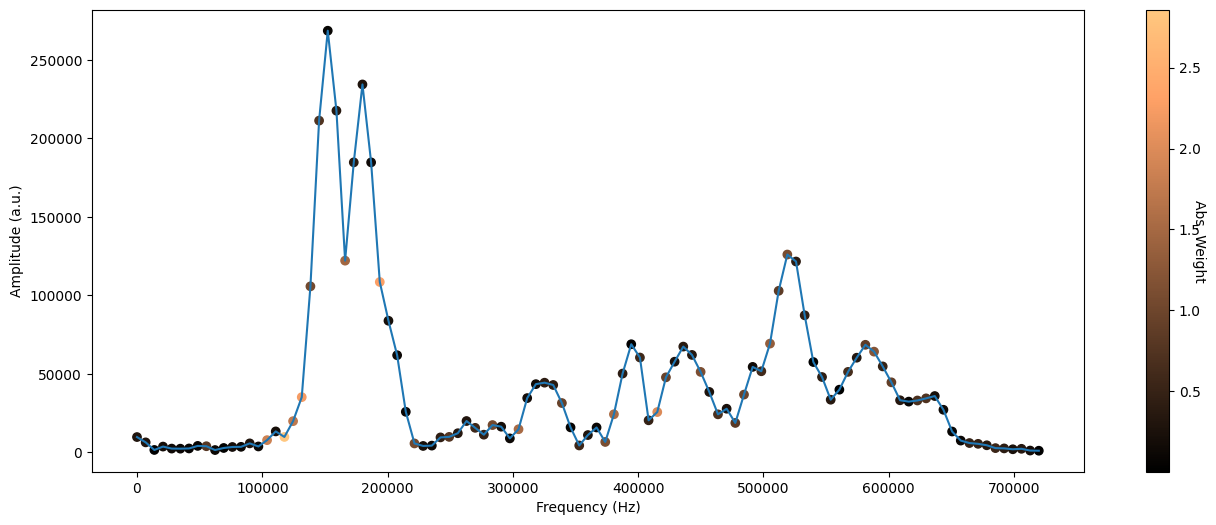

In [31]:
# Plot freq, Amp with imporance
abs_importance = abs(importance)
plt.figure(figsize=(16, 6))
plt.plot(f_loop[0,:], Amp_loop[0,:])
plt.scatter(f_loop[0,:],Amp_loop[0,:],c = abs_importance, cmap = 'copper')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (a.u.)")
# plt.title("Weights")
cbar = plt.colorbar()
cbar.set_label('Abs. Weight', rotation=270)

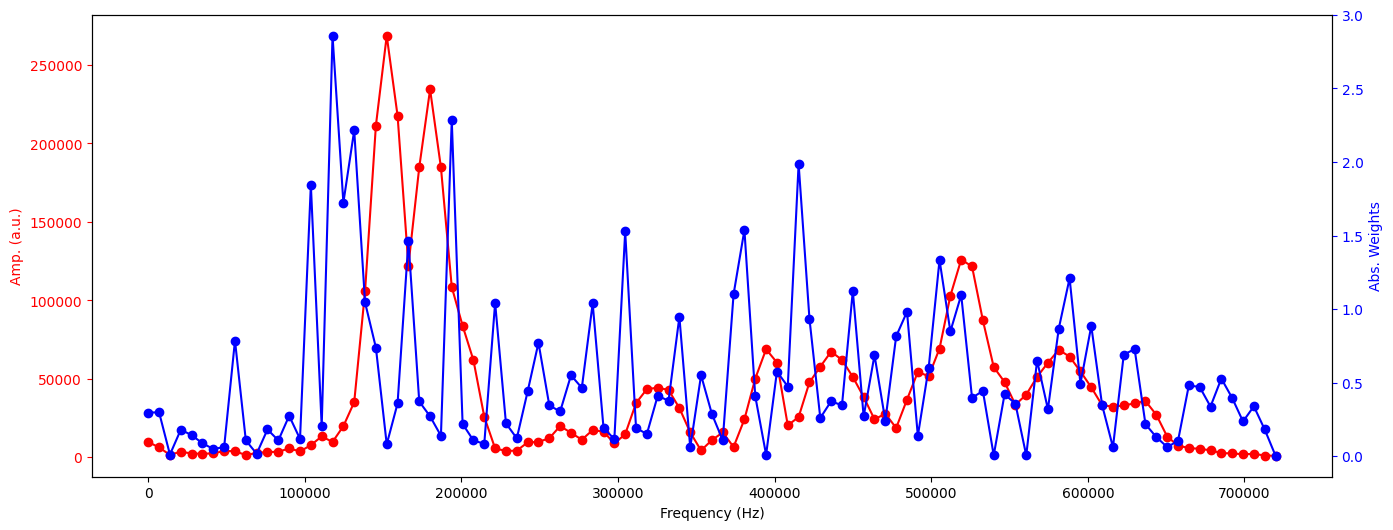

In [32]:
fig, ax1 = plt.subplots(figsize=(16, 6))

ax1.plot(f_loop[0,:], Amp_loop[0,:],"r-o")
ax1.set_ylabel('Amp. (a.u.)', color='r')
ax1.set_xlabel('Frequency (Hz)', color='k')
ax1.tick_params(axis='y', color='r', labelcolor='r')

ax2 = ax1.twinx()
ax2.plot(f_loop[0,:], abs_importance,"b-o")
ax2.set_ylabel('Abs. Weights', color='b')
ax2.tick_params(axis='y', color='b', labelcolor='b')
plt.show()

In [33]:
# Extract new feature (training)
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('Weights_Layer').output)
intermediate_output_train = intermediate_layer_model.predict(X_train)

 199/2896 ━━━━━━━━━━━━━━━━━━━━ 2s 763us/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['Input_Layer']
Received: inputs=Tensor(shape=(32, 105))
  warnings.warn(msg)


2896/2896 ━━━━━━━━━━━━━━━━━━━━ 2s 818us/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['Input_Layer']
Received: inputs=Tensor(shape=(None, 105))
  warnings.warn(msg)


In [34]:
# Extract new feature (validation)
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('Weights_Layer').output)
intermediate_output_val = intermediate_layer_model.predict(X_val)

203/414 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['Input_Layer']
Received: inputs=Tensor(shape=(32, 105))
  warnings.warn(msg)


414/414 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['Input_Layer']
Received: inputs=Tensor(shape=(None, 105))
  warnings.warn(msg)


In [35]:
# Extract new feature (testing)
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('Weights_Layer').output)
intermediate_output_test = intermediate_layer_model.predict(x_test)

195/828 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['Input_Layer']
Received: inputs=Tensor(shape=(32, 105))
  warnings.warn(msg)


828/828 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['Input_Layer']
Received: inputs=Tensor(shape=(None, 105))
  warnings.warn(msg)


In [36]:
 # Combine Features & Output
Amp_Feature = np.vstack((intermediate_output_train, intermediate_output_val, intermediate_output_test))
Amp_Feature = Amp_Feature.ravel()

ydf_new = ydf.to_numpy()
ydf_new = ydf_new.ravel()

In [37]:
# Extract Data
df_SS = np.vstack((Amp_Feature, ydf_new))
savetxt('Features_SS.csv', df_SS, delimiter=',')
files.download('Features_SS.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>